<a href="https://colab.research.google.com/github/0ginny/TIL/blob/main/240416_Classification_of_emotions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of emotions

## Importing the libraries

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab.patches import cv2_imshow
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
%cd /content/gdrive/MyDrive/Colab Notebooks/Vision_AZ

/content/gdrive/MyDrive/Colab Notebooks/Vision_AZ


## Loading the images

In [5]:
path = './Datasets/fer_images.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

### Train and test set

In [9]:
training_generator = ImageDataGenerator( rescale = 1./255,
                                      rotation_range = 7,
                                      horizontal_flip = True,
                                      zoom_range = 0.2)
train_dataset = training_generator.flow_from_directory(directory = './fer2013/train/',
                                                          target_size = (48, 48),
                                                          batch_size = 16,
                                                          class_mode = 'categorical',
                                                          shuffle = True)

Found 28709 images belonging to 7 classes.


In [11]:
train_dataset.class_indices

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

In [12]:
np.unique(train_dataset.classes, return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6], dtype=int32),
 array([3995,  436, 4097, 7215, 4965, 4830, 3171]))

<Axes: ylabel='count'>

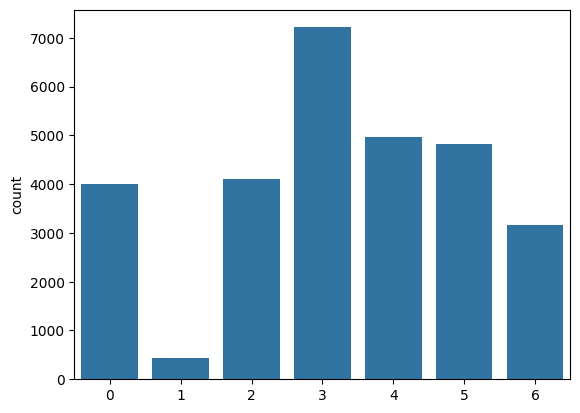

In [13]:
sns.countplot(x = train_dataset.classes)

In [15]:
test_generator = ImageDataGenerator(rescale=1./255)
test_dataset = test_generator.flow_from_directory('./fer2013/validation',
                                                  target_size = (48, 48),
                                                  batch_size = 1,
                                                  class_mode = 'categorical',
                                                  shuffle = False)

Found 3589 images belonging to 7 classes.


## Building and training the convolutional neural network

합성곱 신경망인데, 전이학습? 으로 하려나봐

In [17]:
# Based on: https://github.com/rajeevratan84/DeepLearningCV/blob/master/18.2%20Building%20an%20Emotion%20Detector%20with%20LittleVGG.ipynb

num_detectors = 32
num_classes = 7
width, height = 48, 48
epochs = 100

network = Sequential()

network.add(Conv2D(filters = num_detectors, kernel_size = (3,3), activation = 'relu', padding = 'same' , input_shape = (width, height, 3)  ))
# Padding: https://www.pico.net/kb/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-tensorflow
# padding, same : 열을 추가해서 filter를 맞춰. / valid : filter 사이즈 안맞으면 버려

# 정규화
# BatchNormalization: https://keras.io/api/layers/normalization_layers/batch_normalization/
# 매우 복잡한 모델에서 유리해.
network.add(BatchNormalization())

# 꼭 convolution 후 pooling을 해야하는 이유는 없어.
network.add(Conv2D(filters = num_detectors, kernel_size = (3,3), activation = 'relu', padding = 'same'))
network.add(BatchNormalization())

# Maxpooling
network.add(MaxPooling2D(pool_size = (2,2)))

# Dropout: https://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf
network.add(Dropout(rate = 0.2))

# add layers
network.add(Conv2D(filters = 2* num_detectors, kernel_size = (3,3), activation = 'relu', padding = 'same' ))
network.add(BatchNormalization())
network.add(Conv2D(filters = 2 * num_detectors, kernel_size = (3,3), activation = 'relu', padding = 'same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size = (2,2)))
network.add(Dropout(rate = 0.2))

network.add(Conv2D(filters = 2*2* num_detectors, kernel_size = (3,3), activation = 'relu', padding = 'same' ))
network.add(BatchNormalization())
network.add(Conv2D(filters = 2 * 2* num_detectors, kernel_size = (3,3), activation = 'relu', padding = 'same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size = (2,2)))
network.add(Dropout(rate = 0.2))

network.add(Conv2D(filters = 2*2*2* num_detectors, kernel_size = (3,3), activation = 'relu', padding = 'same' ))
network.add(BatchNormalization())
network.add(Conv2D(filters = 2 * 2*2* num_detectors, kernel_size = (3,3), activation = 'relu', padding = 'same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size = (2,2)))
network.add(Dropout(rate = 0.2))

network.add(Flatten())

network.add(Dense(2 * num_detectors , activation = 'relu'))
network.add(BatchNormalization())
network.add(Dropout(rate = 0.2))

network.add(Dense(2 * num_detectors , activation = 'relu'))
network.add(BatchNormalization())
network.add(Dropout(rate = 0.2))

network.add(Dense(num_classes, activation = 'softmax'))
print(network.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 48, 48, 32)        896       
                                                                 
 batch_normalization_8 (Bat  (None, 48, 48, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization_9 (Bat  (None, 48, 48, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                      

In [18]:
network.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
# 학습은 미리 되있는걸 사용하자.
network.fit(train_dataset, epochs = 100)

## Saving and loading the model

In [19]:
with open('./Weights/network_emotions.json', 'r') as json_file :
    json_saved_model = json_file.read()
json_saved_model

'{"class_name": "Sequential", "config": {"name": "sequential_1", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 48, 48, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "conv2d_8_input"}}, {"class_name": "Conv2D", "config": {"name": "conv2d_8", "trainable": true, "batch_input_shape": [null, 48, 48, 3], "dtype": "float32", "filters": 32, "kernel_size": [3, 3], "strides": [1, 1], "padding": "same", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "BatchNormalization", "config": {"name": "batch_normalization_8", "trainable": true, "dtype": "float32", "axis": [3], "momentum": 0.99, "epsilon": 0

In [20]:
network_loaded = tf.keras.models.model_from_json(json_saved_model)
network_loaded.load_weights('./Weights/weights_emotions.hdf5')
network_loaded.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [21]:
network_loaded.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 48, 48, 32)        896       
                                                                 
 batch_normalization_8 (Bat  (None, 48, 48, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization_9 (Bat  (None, 48, 48, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                      

## Evaluating the neural network

## Classifying one single image

## Classifying multiple images

## Classifying emotions in videos